In [166]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lazypredict.Supervised import LazyClassifier
import joblib
import os
from lightning import seed_everything
from utils import SEED

## Methods

In [167]:
def set_seed(seed=SEED):
    seed_everything(seed)

# Load dataset from pickle file
def read_pickle(filename: str) -> pd.DataFrame:
    with open(filename, 'rb') as f:
        return pd.DataFrame(pickle.load(f))

# Perform t-SNE dimensionality reduction
def apply_tsne(dataset_train):
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(dataset_train["sample"])-1), n_iter=1000)
    return tsne.fit_transform(np.array(dataset_train["sample"].to_list()))

# Plot t-SNE scatter plot
def plot_tsne(X_2d, labels):
    colors = ['red', 'blue']
    plt.figure(figsize=(8, 6))
    for i in range(len(X_2d)):
        plt.scatter(X_2d[i, 0], X_2d[i, 1], color=colors[labels[i]], s=15, alpha=0.7, edgecolor='k')
    plt.legend(['Class 0', 'Class 1'], loc='upper right', fontsize=10, frameon=True)
    plt.title("t-SNE Representation", fontsize=14)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot label distribution as a histogram
def plot_label_distribution(label_counts, title="Distribution of Labels"):
    colors = ['blue', 'red']
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    plt.title(title, fontsize=14)
    plt.xlabel("Labels", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks([0, 1], ['Class 0', 'Class 1'], fontsize=10)
    for i, value in enumerate(label_counts.values):
        plt.text(i, value + 0.5, str(value), ha='center', fontsize=10, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Balance the dataset by downsampling the majority class
def balance_dataset(dataset_train):
    class_majority = dataset_train[dataset_train['label'] == 0]
    class_minority = dataset_train[dataset_train['label'] == 1]
    class_majority_downsampled = class_majority.sample(n=len(class_minority), random_state=42)
    df_balanced = pd.concat([class_majority_downsampled, class_minority])
    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Train and evaluate models using LazyClassifier
def lazy_classification(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, _ = clf.fit(X_train, X_test, y_train, y_test)
    return models

def save_predictions_to_csv(predictions, folder=None, filename="clf_models.csv"):
    assert folder is not None, "Please provide a folder to save the predictions."
    predictions_df = pd.DataFrame(predictions)
    file_path = os.path.join(folder, filename)
    predictions_df.to_csv(file_path, index=True, sep=';')
    print(f"Predictions saved to {file_path}")

# Optimize and evaluate models using RandomizedSearchCV
def optimize_models(X_train, y_train, X_test, y_test):
    models = {
        "RandomForest": (RandomForestClassifier(n_jobs=-1), {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        }),
    }
    best_models = {}
    for model_name, (model, param_grid) in models.items():
        print(f"\nOptimizing {model_name}...")
        grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
        best_models[model_name] = best_model
    return best_models

# Save the best model to a file
def save_model(best_models, model_name, folder="models"):
    os.makedirs(folder, exist_ok=True)
    if model_name in best_models:
        file_path = os.path.join(folder, f"{model_name}_best_model.pkl")
        joblib.dump(best_models[model_name], file_path)
        print(f"Model {model_name} saved as {file_path}")
    else:
        print(f"Model {model_name} not found in best_models.")

In [178]:
def experiments(dataset_train, dataset_test, dataset_train_path):
    plot_label_distribution(dataset_train['label'].value_counts())

    df_balanced = balance_dataset(dataset_train)
    plot_label_distribution(df_balanced['label'].value_counts(), title="Balanced Distribution of Labels")

    X_2d = apply_tsne(dataset_train)
    plot_tsne(X_2d, dataset_train['label'].to_list())

    X_train = np.array(df_balanced["sample"].to_list())
    y_train = np.array(df_balanced["label"].to_list())
    X_test = np.array(dataset_test["sample"].to_list())
    y_test = np.array(dataset_test["label"].to_list())

    models = lazy_classification(X_train, X_test, y_train, y_test)
    folder_to_save = "/".join([f for f in dataset_train_path.split("/")[:-1]])
    save_predictions_to_csv(models, folder=folder_to_save)

    print("#"*50)
    print(models.head(5))

In [168]:
set_seed()

Seed set to 3407


## Chunks embeddings OpenIA

In [179]:
dataset_train_path = "data/04-clustering/spanish-chunks-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-chunks-openai/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

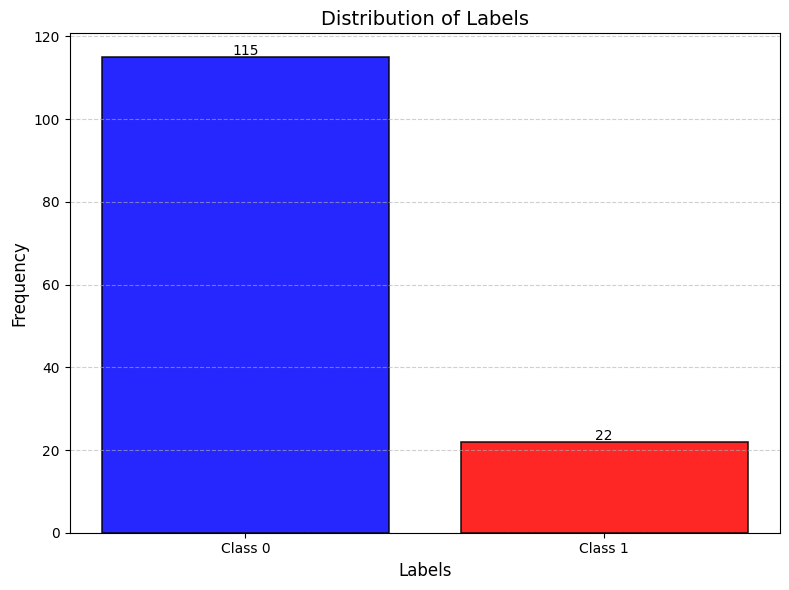

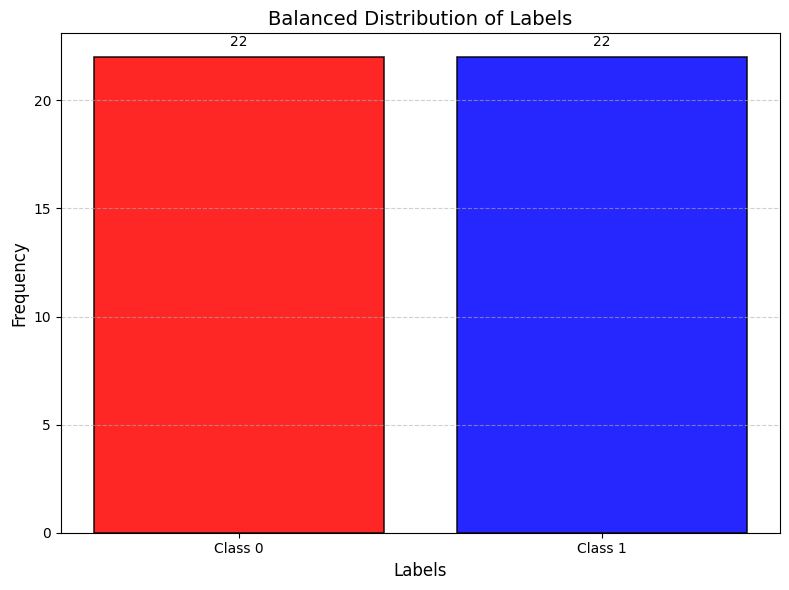

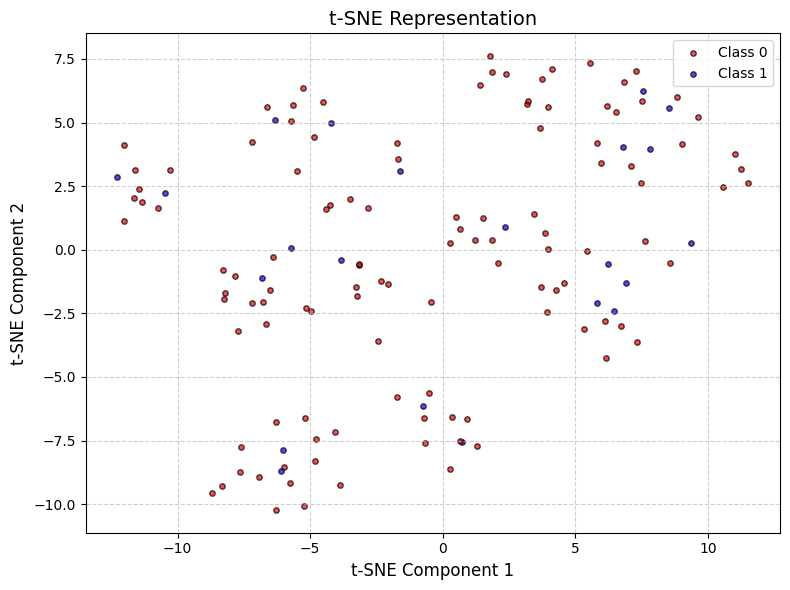

100%|██████████| 31/31 [00:02<00:00, 13.41it/s]

[LightGBM] [Info] Number of positive: 22, number of negative: 22
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50189
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 3072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [180]:
experiments(dataset_train, dataset_test, dataset_train_path)

## Chunks MNLI

In [181]:
dataset_train_path = "data/04-clustering/spanish-chunks-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-chunks-sentence-transformers/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

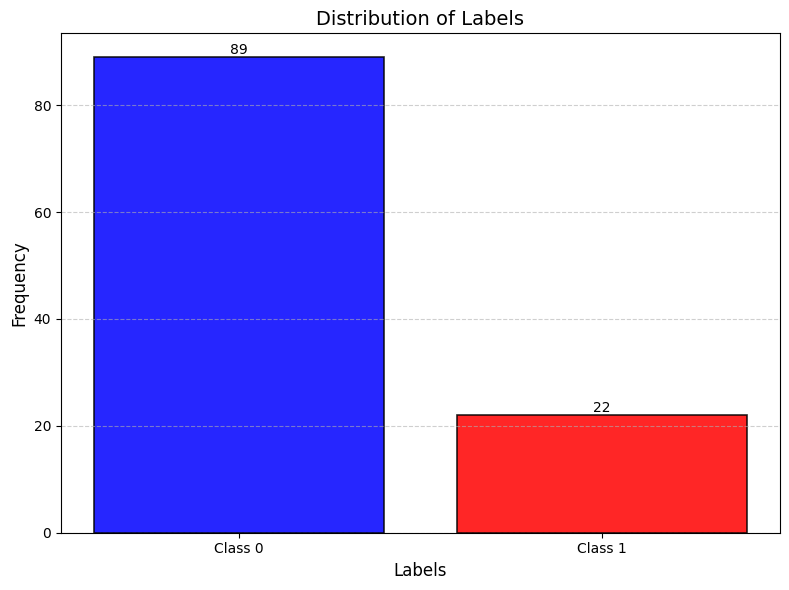

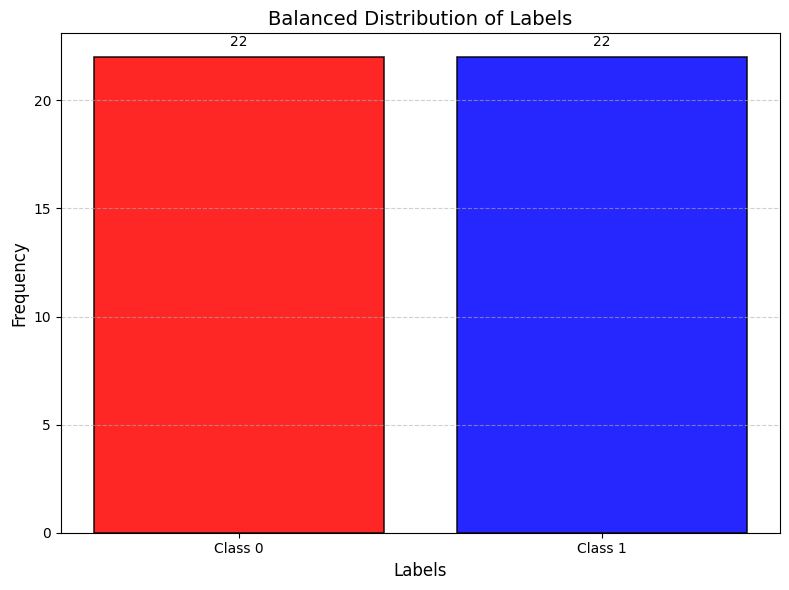

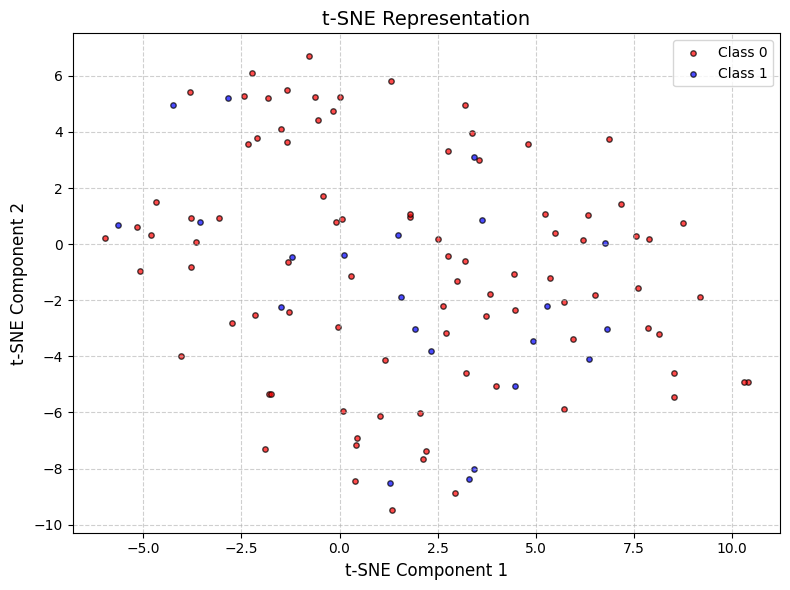

100%|██████████| 31/31 [00:01<00:00, 23.88it/s]

[LightGBM] [Info] Number of positive: 22, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12532
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [182]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-paragraphs-openai

In [183]:
dataset_train_path = "data/04-clustering/spanish-paragraphs-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-paragraphs-openai/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

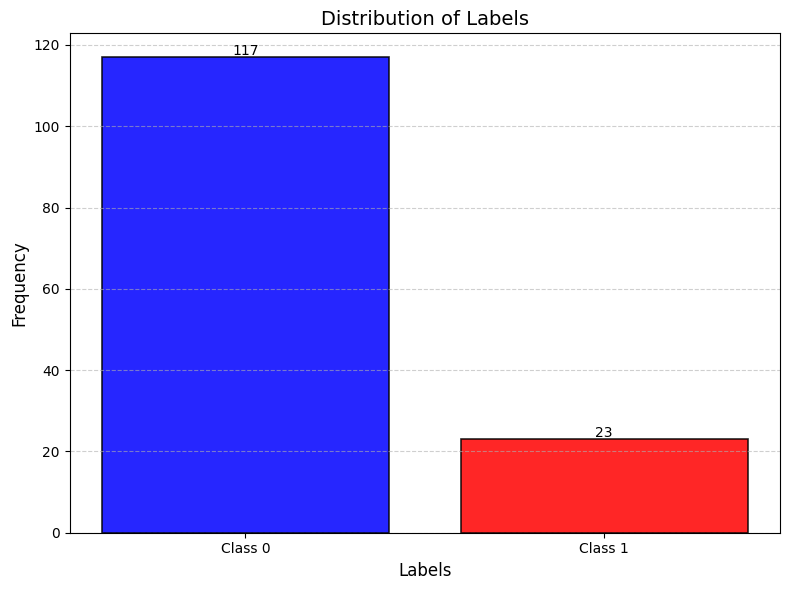

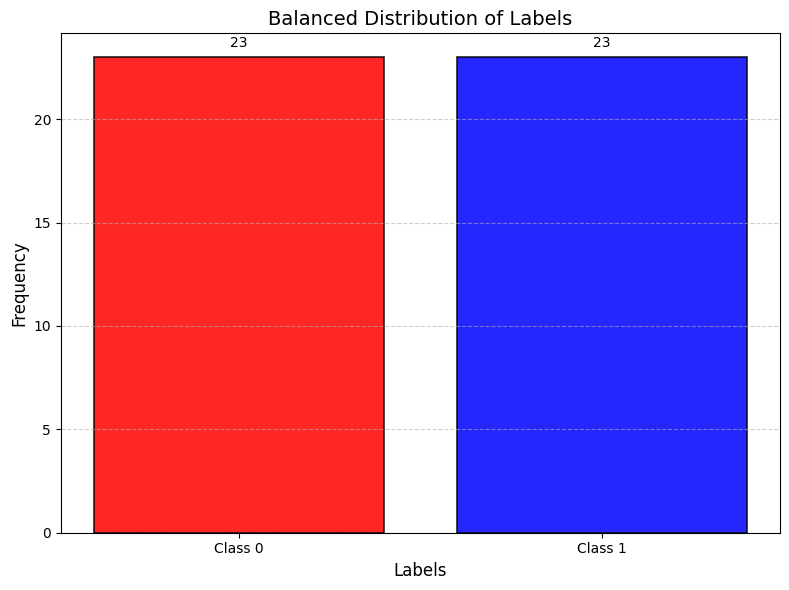

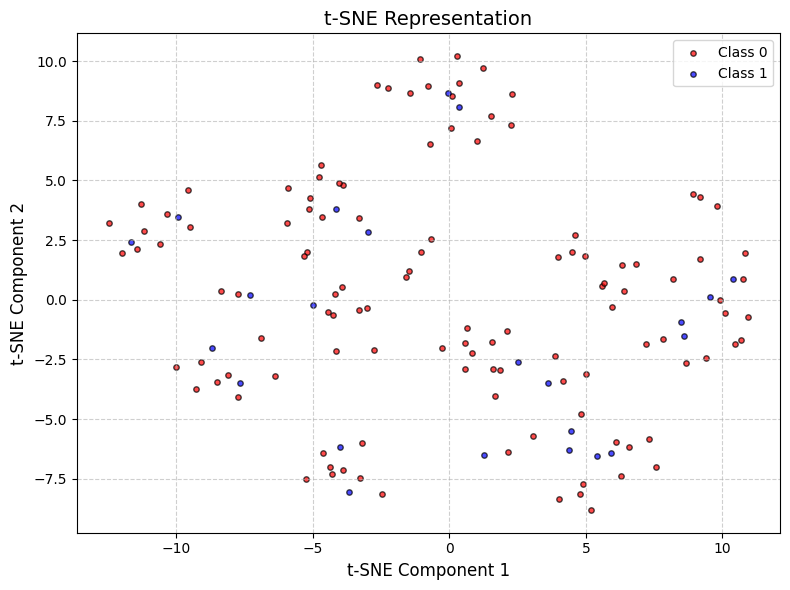

100%|██████████| 31/31 [00:02<00:00, 13.38it/s]

[LightGBM] [Info] Number of positive: 23, number of negative: 23
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 3072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [184]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-paragraphs-sentence-transformers

In [185]:
dataset_train_path = "data/04-clustering/spanish-paragraphs-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-paragraphs-sentence-transformers/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

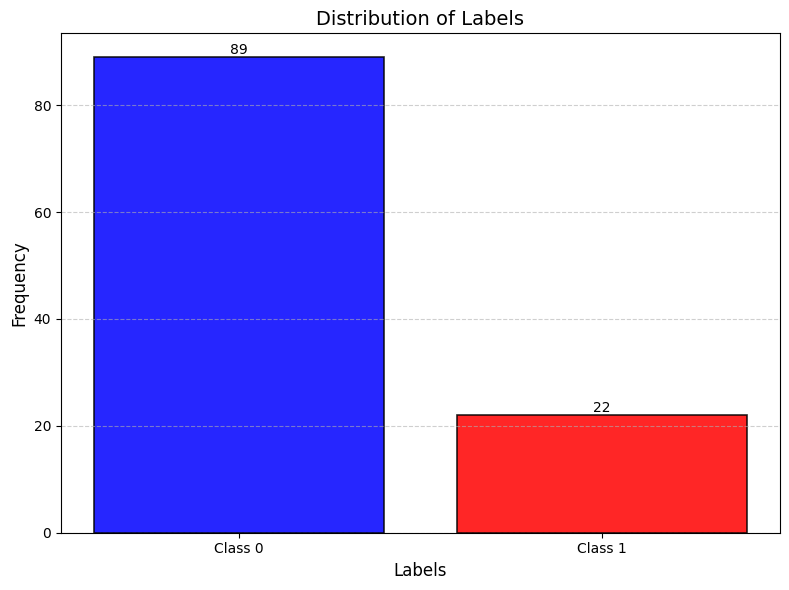

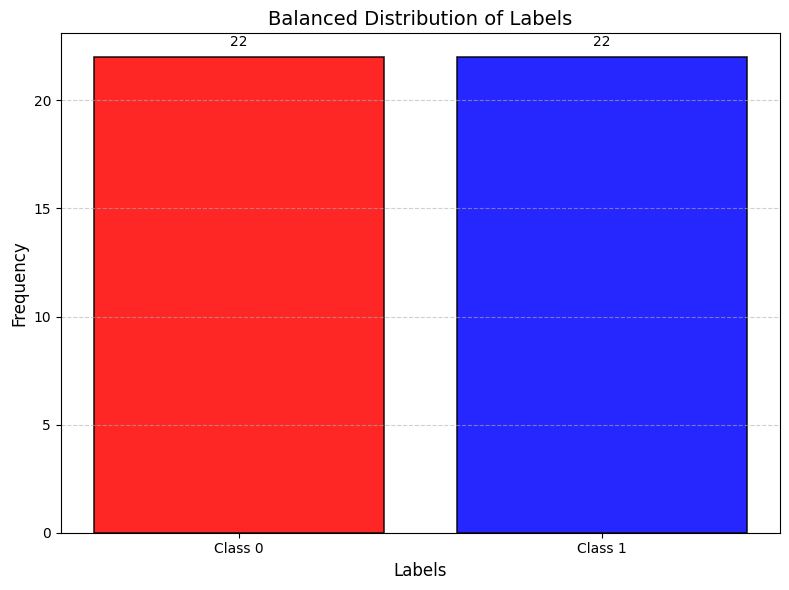

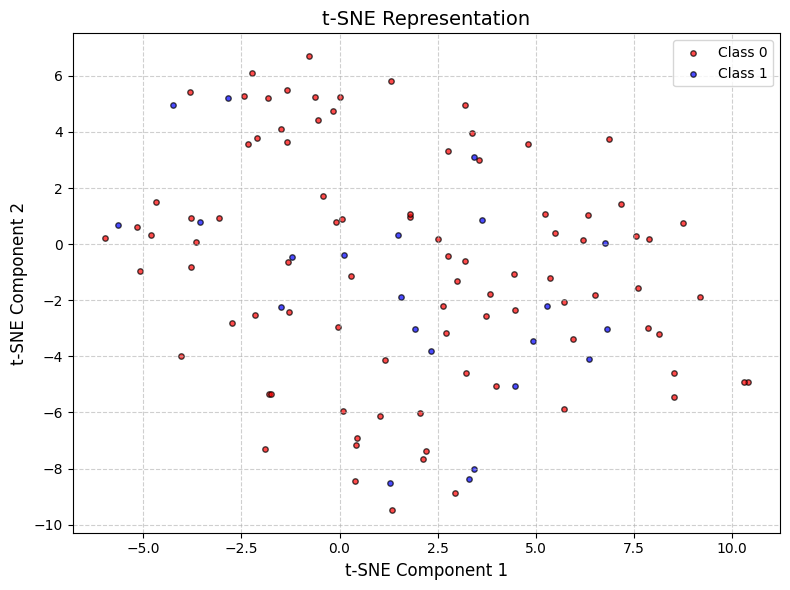

100%|██████████| 31/31 [00:01<00:00, 23.84it/s]

[LightGBM] [Info] Number of positive: 22, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12532
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [186]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-sentences-openai

In [187]:
dataset_train_path = "data/04-clustering/spanish-sentences-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-sentences-openai/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

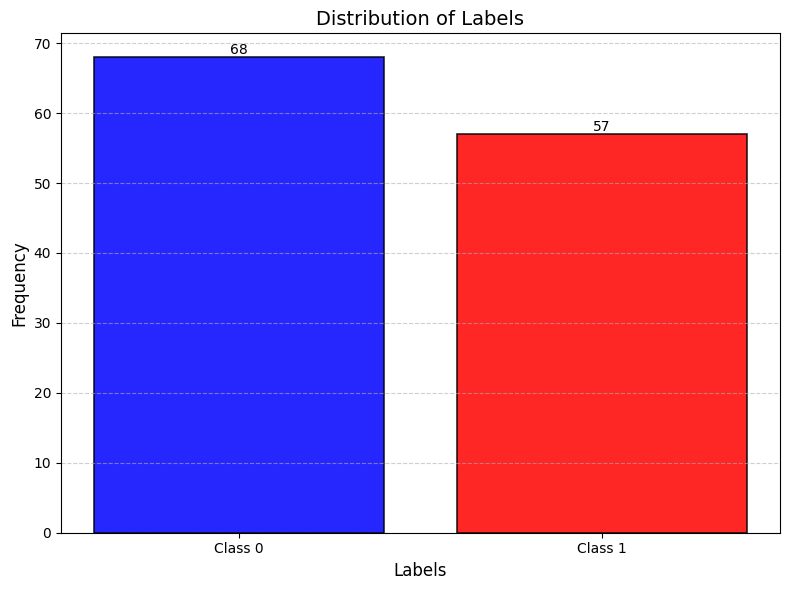

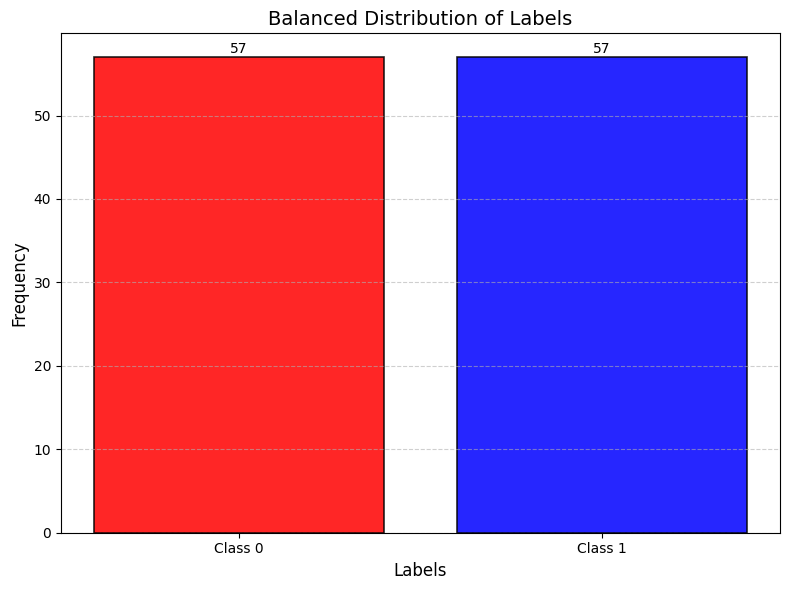

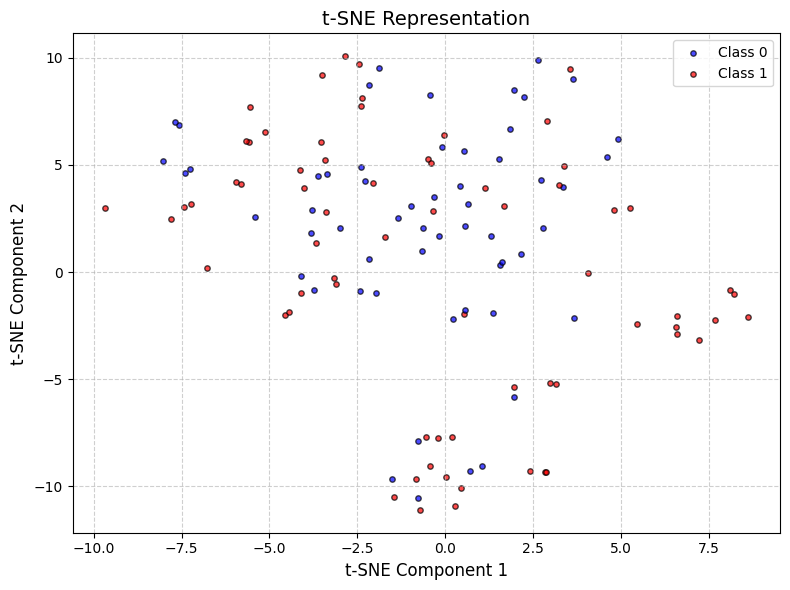

100%|██████████| 31/31 [00:05<00:00,  6.06it/s]

[LightGBM] [Info] Number of positive: 57, number of negative: 57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121883
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 3072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [188]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-sentences-sentence-transformers

In [189]:
dataset_train_path = "data/04-clustering/spanish-sentences-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-sentences-sentence-transformers/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

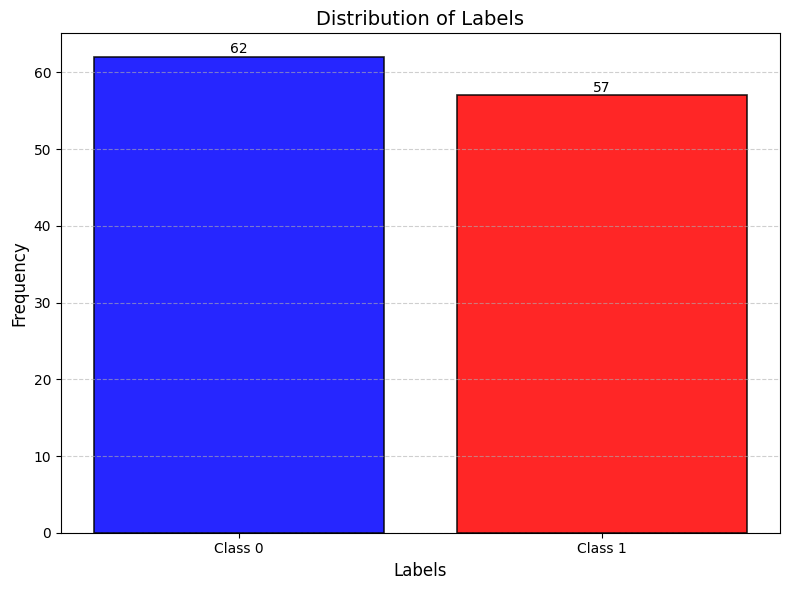

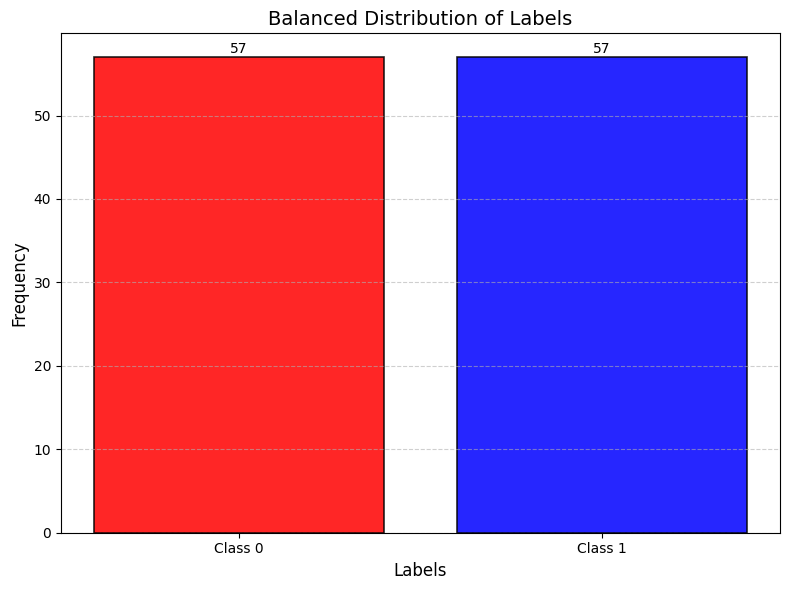

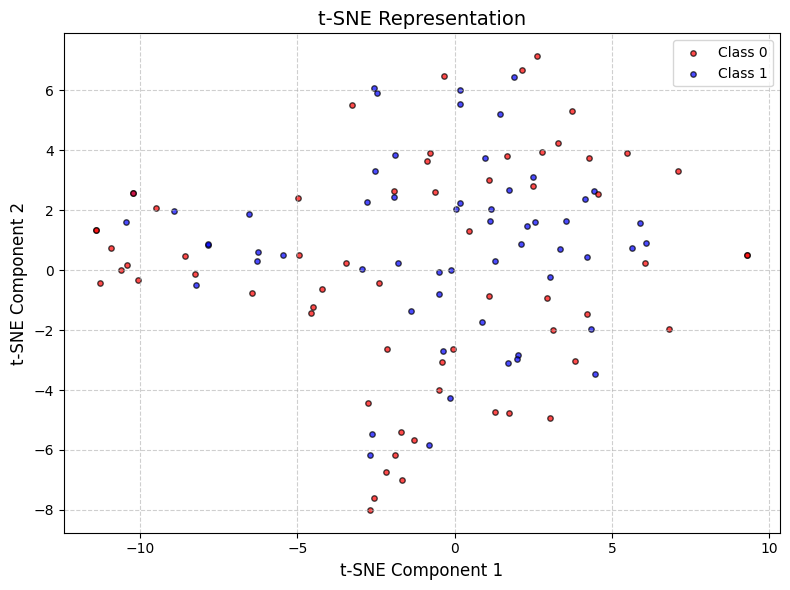

100%|██████████| 31/31 [00:02<00:00, 14.47it/s]

[LightGBM] [Info] Number of positive: 57, number of negative: 57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30442
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [190]:
experiments(dataset_train, dataset_test, dataset_train_path)